In [62]:
import khmer
# ref = https://github.com/dib-lab/khmer/blob/master/examples/python-api/exact-counting.py
import tqdm
import pandas as pd
import numpy as np
import os
import scanpy.api as sc
import anndata as ad
from scipy import sparse
from plotnine import *
import plotnine
from IPython.core.display import HTML


def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [ ]:
# create marker genes file
## ref: https://www.rndsystems.com/research-area/b-cell-markers

In [40]:
dir_path = '/home/ubuntu/data/longread/'
ksize = 5
nkmers = 4**ksize
markers_len = 3

entry_len_list = []
for fn in os.listdir(dir_path):
    if fn.endswith('.fa') and fn != 'markers.fa':
        entry_len_list = entry_len_list+[int(file_len(f'{dir_path}{fn}')/2)]
entry_len_sum = int(np.sum(entry_len_list))
min_entry_len = int(np.min(entry_len_list))
balanced_entry_len_sum = int(min_entry_len*len(entry_len_list))+markers_len

cell_df = pd.DataFrame()
master_df = pd.DataFrame()
kmer_arr = np.zeros((nkmers, balanced_entry_len_sum))

arr_idx = 0
seq_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')
cell_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')

# ingest all .fa files from dir
for fn in os.listdir(dir_path):
    if fn.endswith('.fa'):
    
        # extract fn prefix for cell id
        cell_id = fn.split('.fa')[0]

        # read .fa
        with open(f'{dir_path}{fn}', 'r') as f:

            # random downsample to smallest fn
            for i, l in enumerate(f):
                pass
            
            entry_len = int((i+1)/2)
            if fn != 'markers.fa':
                replace_val = False
            else:
                replace_val = True
            entry_white_list = np.random.choice([x*2 for x in range(entry_len)], 
                                                min_entry_len,
                                                replace = replace_val
                                               ).tolist()
            entry_white_list = [x+1 for x in entry_white_list]+entry_white_list

        with open(f'{dir_path}{fn}', 'r') as f:
            
            # parse entry by entry
            for count, line in tqdm.tqdm(enumerate(f, start=0)):

                # filter on whitelist
                if count in entry_white_list:

                    # extract first line as seq id
                    if count % 2 == 0:
                        k_name = line[1:-1]

                    # extract second line as sequence
                    if count % 2 != 0:

                        # Initialize countgraph
                        tablesize = nkmers + 10
                        ktable = khmer.Countgraph(ksize, tablesize, 1)

                        # count all k-mers in the given string
                        ktable.consume(line[:-1])

                        # capture full kmer counts
                        k_n_list = [ktable.get(i) for i in range(nkmers)]

                        # update kmer count arr
                        kmer_arr[:,arr_idx] = k_n_list 

                        # log sequence and cell names for metadata
                        seq_id_arr[arr_idx] = k_name
                        cell_id_arr[arr_idx] = cell_id

                        # update arr pointer
                        arr_idx = arr_idx + 1

# create dfs
kmers_list = [ktable.reverse_hash(i) for i in range(nkmers)]
master_df = pd.DataFrame(kmer_arr)
master_df['kmers'] = kmers_list
master_df = master_df.set_index('kmers')
master_df.columns = seq_id_arr.tolist()
cell_df = pd.DataFrame({'seq_id':seq_id_arr,
                        'cell_id':cell_id_arr,
                       })
cell_df = cell_df.set_index('seq_id')


3326it [00:00, 5874.58it/s]
11746it [00:01, 10203.22it/s]
34966it [00:02, 13696.45it/s]
9786it [00:01, 9351.32it/s]
10186it [00:01, 9807.17it/s]
7562it [00:00, 8778.89it/s]
4412it [00:00, 6126.97it/s]
3540it [00:00, 5681.19it/s]
12092it [00:01, 10257.11it/s]
6410it [00:00, 7582.84it/s]
5326it [00:00, 7084.39it/s]
6058it [00:00, 7480.73it/s]
6it [00:00, 3092.76it/s]


In [43]:
# ingest data to adata obj

# pd df to np array
array_adata = master_df.values

# extract obs and var
obs = master_df.columns.tolist()
gene_names = master_df.index.tolist()

# create ad obj
adata = ad.AnnData(X=array_adata).T
adata.X = sparse.csr_matrix(adata.X)
adata.var_names = gene_names
adata.obs_names = obs

# append metadata
adata.obs['cell_id'] = cell_df.cell_id.tolist()

# transform and freeze raw state
adata.raw = sc.pp.log1p(adata, copy=True)

# embed and cluster
n_pcs = 10
n_neighbs = 15
min_dist = 0.5

all_forms_adata = sc.pp.log1p(adata, copy=True) 
sc.pp.scale(all_forms_adata) 
sc.tl.pca(all_forms_adata, use_highly_variable = False, n_comps=n_pcs, random_state=1) 
sc.pp.neighbors(all_forms_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=1) 
sc.tl.umap(all_forms_adata, min_dist = min_dist, random_state=1)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


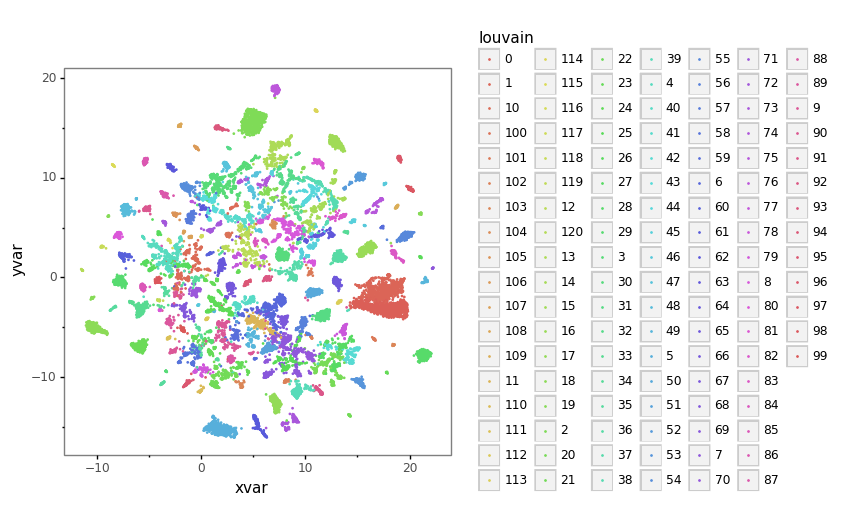

<ggplot: (8777579255700)>


In [83]:
louvain_res = 2
sc.tl.louvain(all_forms_adata, resolution = louvain_res, random_state=1)

umap_df = pd.DataFrame(all_forms_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['cell_id'] = all_forms_adata.obs.cell_id.tolist()
umap_df['seq_id'] = all_forms_adata.obs.index.tolist()
umap_df['louvain'] = all_forms_adata.obs.louvain.tolist()
umap_df['marker_highlight'] = [x == 'markers' for x in umap_df['cell_id']]

plotnine.options.figure_size = (5,5)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='louvain'), size=0.1)
       )
print(plot)

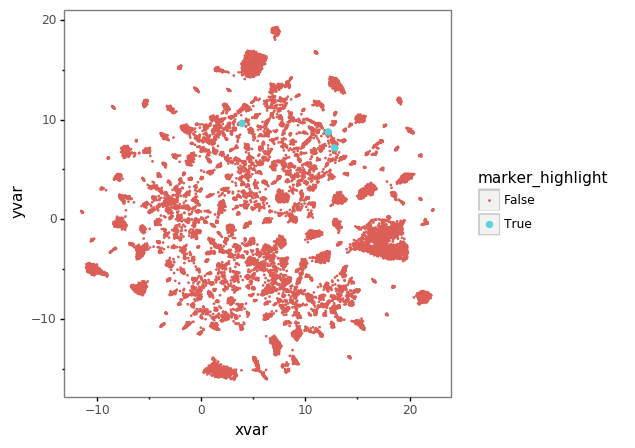

<ggplot: (8777581073868)>


In [45]:
plotnine.options.figure_size = (5,5)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='marker_highlight', size='marker_highlight'))
        + scale_size_manual(values = {True:2, False:0.1})
       )
print(plot)

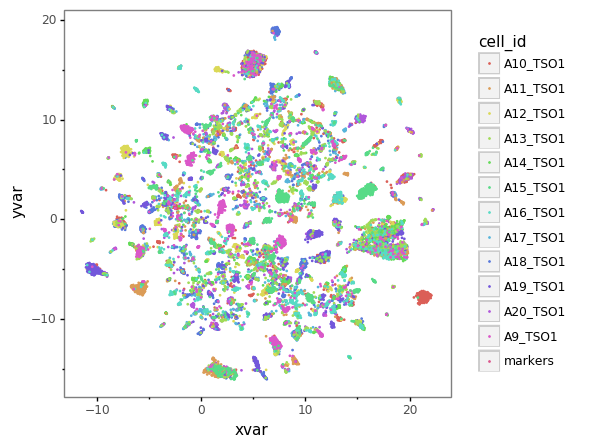

<ggplot: (-9223363259278451782)>


In [46]:
plotnine.options.figure_size = (5,5)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='cell_id'), size=0.1)
       )
print(plot)

In [84]:
c = umap_df.groupby(['louvain'])['cell_id'].value_counts().rename("proportion")
pd.DataFrame(c/c.groupby(level=0).sum()).sort_values('proportion', ascending = False).head(40)

,,proportion
louvain,cell_id,
119,A10_TSO1,1.000000
28,A10_TSO1,0.986784
64,A9_TSO1,0.970588
106,A16_TSO1,0.958333
120,A19_TSO1,0.933333
98,A12_TSO1,0.928571
22,A11_TSO1,0.928270
57,A9_TSO1,0.919463
30,A15_TSO1,0.917051


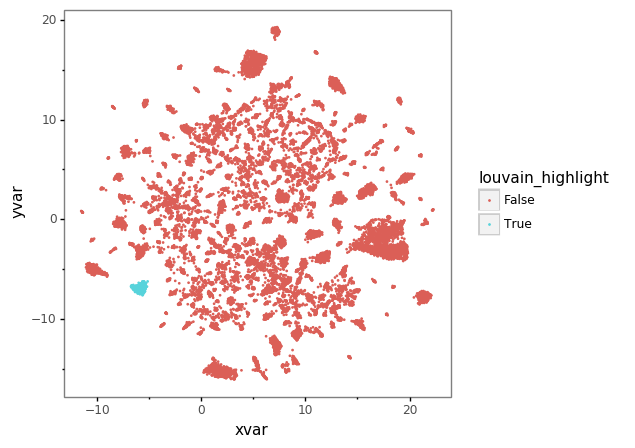

<ggplot: (-9223363259281955612)>


,cell_id,seq_id
538,A10_TSO1,5e36c740-fff5-48bd-a61f-6a1042704184_12.84_621...
911,A10_TSO1,f9c80f6a-b5c3-4dec-8450-81bacce90ddc_12.6_2277...
987,A10_TSO1,125c1498-8f55-43b9-8bb9-733a3c4db63c_13.77_334...
1205,A10_TSO1,1c042e75-7cc0-4281-9aac-7d68528e28c7_13.35_175...
6555,A18_TSO1,61f2e6e2-3470-41d4-b22b-c15186f1f724_12.53_414...
...,...,...
17296,A9_TSO1,29fb5f6d-15d3-4144-8aa3-6d254396207d_11.87_709...
17322,A9_TSO1,e0d46dc7-ef29-4687-aa2a-0b14a3015787_11.57_620...
17421,A9_TSO1,f353209e-d4ad-49ca-aeef-9f04a02ffdb2_10.29_104...
18916,A15_TSO1,f8867e25-490f-4c03-a8ce-f1414ba9205c_13.05_375...


In [87]:
louvain_cluster = '22'
umap_df['louvain_highlight'] = [x == louvain_cluster for x in umap_df.louvain]

plotnine.options.figure_size = (5,5)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='louvain_highlight'), size=0.1)
       )
print(plot)

cluster_slice = umap_df[umap_df.louvain == louvain_cluster].loc[:,['cell_id','seq_id']]
display(cluster_slice)

In [88]:
slice_idx = 0
slice_slice = cluster_slice.iloc[slice_idx,:]
fa_prefix = slice_slice.cell_id
seq_id = slice_slice.seq_id
fn = f'{fa_prefix}.fa'
with open(f'{dir_path}{fn}', 'r') as f:
            
    # parse entry by entry
    capture_count = -1
    for count, line in tqdm.tqdm(enumerate(f, start=0)):
        if line == f'>{seq_id}\n':
            capture_count = count+1
        if capture_count != -1 and capture_count == count:
            print(line)
        

3326it [00:00, 393075.66it/s]

CCGAGATCTACACAAAGCTATTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGTGAATTCTGGTGGGAAGTCTGAGAGAAACCAAAAAATAATCGGAAACCAGCTGCCCCAAAGGAACCAGGAGGTGAAAACAAAACAAAAACCAAAACAAAACCAAAAAAAAAAACCCACAAAATCAAACAAAAAACAGTCGCGAGGTGAGCTGCGGCCTTAACAGCAGGGCTGGTGGCTGGAACGCGGTGCCCAGATGGTCGCGAGGAGGAGCCAGACCTCAGTGCTCACCCCCTCACCTTCGACGCCCCACAAAAACCAGCCATCTGCGGAGAAGCCCAGCAGGTCAGGTTGATGCCCACTGAGCCCTGGCGGGACCAACCCCAACCCTGCTTCCCAGTCCCCCGTGGGCCTACAGAAGGCCAAAAAGAGAAGACGGGCGATCCTTCCAAAGCCAGGTAACAACTCGTTCCTAATCCCTGATAGCCCCCAGCCCCACGTGCTGTGTTATGGTCCATGCCCTGAAGACAGGGCACAGCCTGGGCGCATGGGCCTTCTGGACCTGGTTCAGCACCACCCACCAAATGTTCTCTTTTCCAGAAGGTGAAAGAGAAAGGGCCTGAACAACCTACACCAAATATTCAGTAGCTTCATCCAAAGGATGTACAGAATTTTTAGCATTGTCCAGCCTGGAATGTGTCCCTACCATGTGTCCCCTTTCTCCCTGGCCCCCAGCTGTGAGCTGCCCAGTGGGCAGGGGTCTTGCCCAACGCCTCCTCCTCCCCCAGCAGGGAGAGTTCAAGGAAGGCCCCAAGACAACTTTTCATCCCCTGTTCCTCCCTCTTTCCCTTTGAAGGGTGGCTATTTTGCCAAGTTCTAGCTCACAAGTCCCTCCTCAACCCTGTCACCCCTCCTCTGTTTGAACTGACTCCTCCCAGCCTATGGGAAGGTGGAAATTTCAGGCAAGAGGGGATGAAGACATTCAGTTGAGGGCATTCAGTTGTCTTT